---
title: "Data Cleaning"
format:
    html: 
        code-fold: false
---

<!-- After digesting the instructions, you can delete this cell, these are assignment instructions and do not need to be included in your final submission.  -->

{{< include instructions.qmd >}} 

# Code 

Provide the source code used for this section of the project here.

If you're using a package for code organization, you can import it at this point. However, make sure that the **actual workflow steps**—including data processing, analysis, and other key tasks—are conducted and clearly demonstrated on this page. The goal is to show the technical flow of your project, highlighting how the code is executed to achieve your results.

If relevant, link to additional documentation or external references that explain any complex components. This section should give readers a clear view of how the project is implemented from a technical perspective.

Remember, this page is a technical narrative, NOT just a notebook with a collection of code cells, include in-line Prose, to describe what is going on.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sodapy import Socrata
from scipy.stats import skew
pd.set_option('future.no_silent_downcasting', True)

In [177]:
# Read in excel data
all_sheets = pd.read_excel('../../data/raw-data/202223-hs-sqr-results.xlsx', skiprows=3, nrows=506, sheet_name=None)

In [379]:
# Concat 4 dicts of sheets
df = pd.concat(all_sheets.values(), axis=1)

# pre cleaning df.head check
df.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,DBN,School Name,School Type,Enrollment,Rigorous Instruction Rating,Collaborative Teachers Rating,Supportive Environment Rating,Effective School Leadership Rating,Strong Family-Community Ties Rating,Trust Rating,Student Achievement Rating,Rigorous Instruction - Percent Positive,Collaborative Teachers - Percent Positive,Supportive Environment - Percent Positive,Effective School Leadership - Percent Positive,Strong Family-Community Ties - Percent Positive,Trust - Percent Positive,Quality Review - How interesting and challenging is the curriculum,Quality Review - How effective is the teaching and learning,Quality Review - How well does the school assess what students are learning,Quality Review - How clearly are high expectations communicated to students and staff,Quality Review - How well do teachers work with each other,Quality Review - How safe and inclusive is the school while supporting social-emotional growth,Quality Review - How well does the school allocate and manage resources,"Quality Review - How well does the school identify, track, and meet its goals",Quality Review - How thoughtful is the school's approach to teacher development and evaluation,Quality Review - How well are school decisions evaluated and adjusted,Quality Review - Dates of Review,Average Grade 8 English Proficiency,Average Grade 8 Math Proficiency,Percent Female,Percent Male,Percent Neither Female nor Male,Percent English Language Learners,Percent Students with IEPs,Percentage of students recommended for general ed settings with Special Ed Teacher Support Services (SETSS),Percentage of students recommended for Integrated Co-Teaching (ICT) services,Percentage of students recommended for Special Class (SC) services,Economic Need Index,Percent Overage / Undercredited,Percent in Temp Housing,Percent HRA Eligible,Student Percent - Asian,Student Percent - Black,Student Percent - Hispanic,Student Percent - Native American,Student Percent - Native Hawaiian or Pacific Islander,Student Percent - White,Teacher Percent - Asian,Teacher Percent - Black,Teacher Percent - Hispanic,Teacher Percent - Native American,Teacher Percent - Native Hawaiian or Pacific Islander,Teacher Percent - White,Nearby Student Distance (mi),Nearby Student Percent - Asian,Nearby Student Percent - Black,Nearby Student Percent - Hispanic,Nearby Student Percent - Native American,Nearby Student Percent - Native Hawaiian or Pacific Islander,Nearby Student Percent - White,Borough Percent - Asian,Borough Percent - Black,Borough Percent - Hispanic,Borough Percent - Native American,Borough Percent - Native Hawaiian or Pacific Islander,Borough Percent - White,Percentage of Students Enrolled in an AP Course,Percentage of Students Enrolled in an IB Course,Percentage of Students Enrolled in a College Level Examination Program (CLEP),Percentage of Students Enrolled in an Advanced Math or Science Course,Percentage of Students Enrolled in an NYCPS-certified College Preparatory Course,Percentage of Students Enrolled in a College Credited Course,Percentage of Students Enrolled in Any Advanced Course,Percentage of Students Enrolled in Advanced Courses - Asian,Percentage of Students Enrolled in Advanced Courses - Black,Percentage of Students Enrolled in Advanced Courses - Hispanic,Percentage of Students Enrolled in Advanced Courses - Native American,Percentage of Students Enrolled in Advanced Courses - Native Hawaiian or Pacific Islander,Percentage of Students Enrolled in Advanced Courses - White,Percentage of Students Enrolled in AP or IB Courses - Asian,Percentage of Students Enrolled in AP or IB Courses - Black,Percentage of Students Enrolled in AP or IB Courses - Hispanic,Percentage of Students Enrolled in AP or IB Courses - Native American,Percentage of Students Enrolled in AP or IB Courses - Native Hawaiian or Pacific Islander,Percentage of Students Enrolled in AP or IB Courses - White,Years of principal experience at this school,Percent of teachers with 3 or more years 

In [380]:
#Pre Cleaning data types
df.dtypes.value_counts()

float64    346
object     317
Name: count, dtype: int64

In [381]:
#make N<15 NA
df = df.replace('N<15', np.nan).infer_objects(copy=False)
df = df.replace('N<5', np.nan).infer_objects(copy=False)
#make values '<95%' as max 95%
df = df.replace('> 95%', int(0.95)).infer_objects(copy=False)

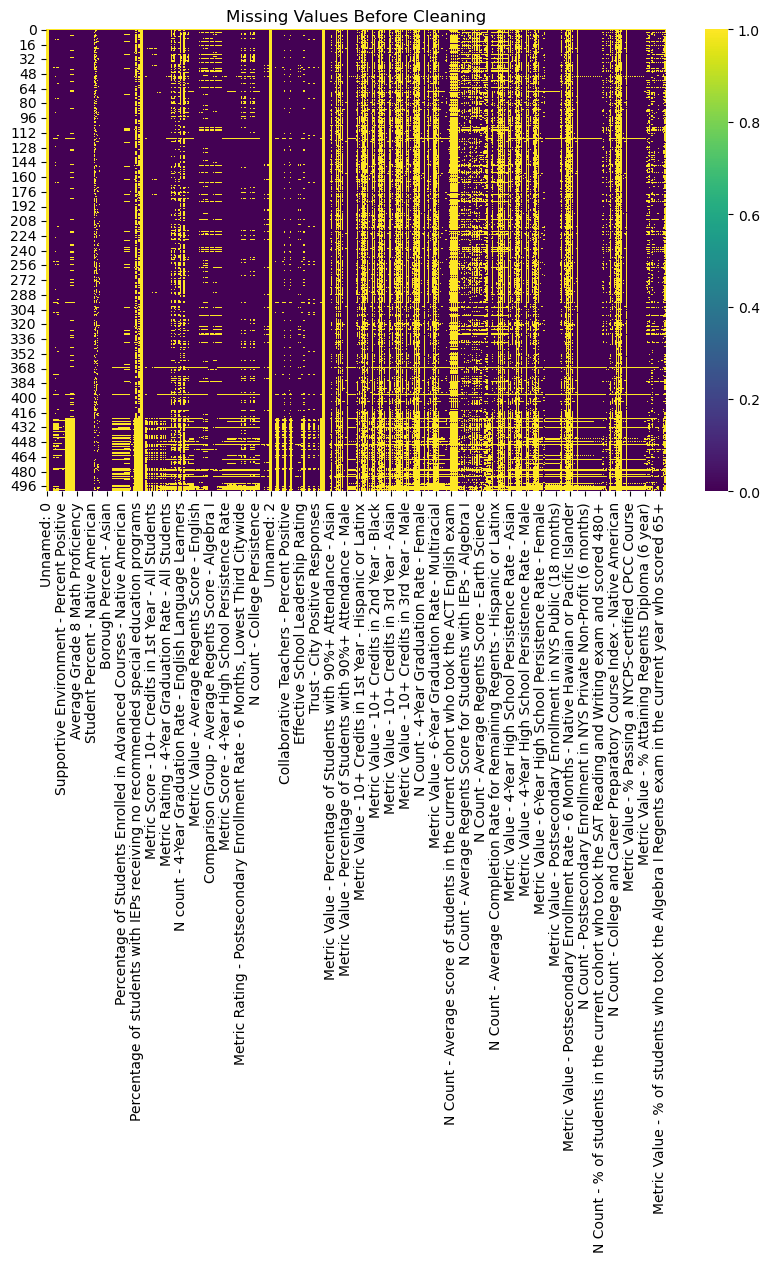

In [382]:
# check pre cleaning missingness
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=True, cmap="viridis")
plt.title("Missing Values Before Cleaning")
plt.show()

In [383]:
#columns to remove by string
#Unnamed: remove NA columns
#N count / metric rating / metric score / comparison group: we just need metric value % columns, these give the same info
#positive responses / percent positive: remove borough and city positive response columns - we just need element score for these metrics
#quality review: these metrics are included in the Element score metrics
string_check = "Unnamed|N count|metric rating|metric score|comparison group|positive responses|percent positive|Quality Review"

#we dont need granularity of scores by specific courses
specific_courses = "Chemistry|Earth Science|Algebra|US History|Geometry|Global History|Living Environment|Credits"

#exclude granularity of demographics
demographics = 'Asian|White|Native|Black|Hispanic|Male|Female|English Lang|ELL|IEPs|NYSAA'

df = df.loc[:, ~df.columns.str.contains(string_check, regex=True, case=False)]
df = df.loc[:, ~df.columns.str.contains(specific_courses, regex=True, case=False)]
#df = df.loc[:, ~df.columns.str.contains(demographics, regex=True, case=False)]

df= df.loc[:, ~(df.columns.str.contains(demographics, regex=True, case=False) & ~(df.columns.str.contains('percent ', regex=True, case=False)))]

In [384]:
#drop duplicated columns
df = df.loc[:, ~df.T.duplicated(keep='first')]
#drop School Type (they are all High Schools) and columns with survey response questions, we have score columns for this
df = df.drop(columns=['School Type','Rigorous Instruction Rating','Collaborative Teachers Rating','Supportive Environment Rating','Effective School Leadership Rating','Strong Family-Community Ties Rating','Trust Rating','Student Achievement Rating'], axis=1)
#remove first row
df = df.iloc[1: , :]

### Feature Engineering

In [385]:
#average rates that are 4 and 6 years then drop
df['Graduation Rate'] = df[['Metric Value - 6-Year Graduation Rate - All Students', 'Metric Value - 4-Year Graduation Rate - All Students']].mean(axis=1)
df['% Attaining Regents Diploma'] = df[['Metric Value - % Attaining Regents Diploma (4 year)', 'Metric Value - % Attaining Regents Diploma (6 year)']].mean(axis=1)
df['High School Persistence Rate'] = df[['Metric Value - 6-Year High School Persistence Rate', 'Metric Value - 4-Year High School Persistence Rate']].mean(axis=1)
df = df.drop(columns=['Metric Value - 6-Year Graduation Rate - All Students',
                    'Metric Value - 4-Year Graduation Rate - All Students',
                    'Metric Value - % Attaining Regents Diploma (4 year)',
                    'Metric Value - % Attaining Regents Diploma (6 year)',
                    'Metric Value - 4-Year High School Persistence Rate',
                    'Metric Value - 6-Year High School Persistence Rate'])

In [386]:
df.loc[:, df.columns.str.contains('Teacher')]

,Percentage of students recommended for general ed settings with Special Ed Teacher Support Services (SETSS),Teacher Percent - Asian,Teacher Percent - Black,Teacher Percent - Hispanic,Teacher Percent - Native American,Teacher Percent - Native Hawaiian or Pacific Islander,Teacher Percent - White,Teacher Attendance Rate,Collaborative Teachers - Element Score,Teacher Survey Response Rate
1,0.000,0.200,NaN,NaN,0.0,0.0,0.480,0.969,4.09,80%
2,0.002,0.154,NaN,0.154,0.0,0.0,0.513,0.971,4.64,95%
3,0.000,NaN,0.169,0.323,0.0,0.0,0.400,0.952,4.59,85%
4,0.000,0.175,0.062,0.072,0.0,0.0,0.649,0.953,3.69,75%
5,0.009,0.256,NaN,0.116,0.0,0.0,0.512,0.953,2.82,43%
...,...,...,...,...,...,...,...,...,...,...
497,0.012,NaN,0.636,0.273,NaN,NaN,NaN,NaN,3.36,35%
498,0.030,NaN,0.476,0.310,NaN,NaN,0.190,NaN,NaN,NaN
499,0.158,NaN,NaN,0.471,0.0,0.0,0.294,NaN,NaN,NaN
500,0.002,0.052,0.459,0.174,NaN,0.0,0.151,0.960,3.90,36%


In [387]:
#Combine student demographic percentages - group black and hispanic since its the majority
df['Student Percent - Black and Hispanic'] = (df['Student Percent - Black'] + df['Student Percent - Hispanic'])
df['Student Percent - Other'] = df['Student Percent - Native American'] + df['Student Percent - Native Hawaiian or Pacific Islander'] + df['Student Percent - Asian'] + df['Student Percent - White']
df = df.drop(['Student Percent - White','Student Percent - Native American', 'Student Percent - Native Hawaiian or Pacific Islander','Student Percent - Asian', 'Student Percent - Black', 'Student Percent - Hispanic'], axis=1)

#Combine teacher demographic percentages - 2 groups: Teacher White and Teacher Other
df['Teacher - Other'] = df['Teacher Percent - Native American'] + df['Teacher Percent - Native Hawaiian or Pacific Islander'] + df['Teacher Percent - Asian'] + df['Teacher Percent - Hispanic'] + df['Teacher Percent - Black']
df = df.drop(['Teacher Percent - Native American', 'Teacher Percent - Native Hawaiian or Pacific Islander','Teacher Percent - Asian', 'Teacher Percent - Black', 'Teacher Percent - Hispanic'], axis=1)

#Remove nearby student percentages
#df['Nearby Student Percent - Black and Hispanic'] = (df['Nearby Student Percent - Black'] + df['Nearby Student Percent - Hispanic'])
#df['Nearby Student Percent - Other'] = df['Nearby Student Percent - Native American'] + df['Nearby Student Percent - Native Hawaiian or Pacific Islander'] + df['Nearby Student Percent - Asian'] + df['Nearby Student Percent - White']
df = df.drop(['Nearby Student Percent - White','Nearby Student Percent - Native American', 'Nearby Student Percent - Native Hawaiian or Pacific Islander','Nearby Student Percent - Asian', 'Nearby Student Percent - Black', 'Nearby Student Percent - Hispanic'], axis=1)

#Remove Borough Percentages
#df['Borough Percent - Black and Hispanic'] = (df['Borough Percent - Black'] + df['Borough Percent - Hispanic'])
#df['Borough Percent - Other'] = df['Borough Percent - Native American'] + df['Borough Percent - Native Hawaiian or Pacific Islander'] + df['Borough Percent - Asian'] + df['Borough Percent - White']
df = df.drop(['Borough Percent - White','Borough Percent - Native American', 'Borough Percent - Native Hawaiian or Pacific Islander','Borough Percent - Asian', 'Borough Percent - Black', 'Borough Percent - Hispanic'], axis=1)

In [388]:
#only keep general postsecondary enrollment and graduation columns
df = df.loc[:, ~((df.columns.str.contains("postsecondary enrollment", case=False)) & ~(df.columns == "Metric Value - Postsecondary Enrollment Rate"))]
df= df.loc[:, ~(df.columns.str.contains('graduated|graduation', regex=True, case=False) & ~(df.columns == "Graduation Rate"))]

In [389]:
#extract District and Borough from DBN column - DBN: (##(District)X(Borough)###(School ID))
df = df.copy()
df['District'] = df['DBN'].str[0:2]
df['Borough'] = df['DBN'].str[2:3]

#map borough name to value
borough_map = {'M': 'Manhattan', 'K': 'Brooklyn', 'X': 'Bronx', 'Q':'Queens', 'R':'Staten Island'}
df['Borough'] = df['Borough'].map(borough_map) 

In [390]:
#combine ACT metrics
df['Percent who took ACT'] = df[['Metric Value - % of cohort who took the ACT English exam','Metric Value - % of cohort who took the ACT Reading exam']].mean(axis=1)
df['Percent with 20+ ACT'] = df[['Metric Value - % of students in the current cohort who took the ACT English exam who scored 20+','Metric Value - % of students in the current cohort who took the ACT Math exam who scored 21+']].mean(axis=1)
df = df.drop(['Metric Value - % of cohort who took the ACT English exam','Metric Value - % of cohort who took the ACT Reading exam','Metric Value - % of students in the current cohort who took the ACT English exam who scored 20+','Metric Value - % of students in the current cohort who took the ACT Math exam who scored 21+'], axis=1)

#SAT metrics
df['Percent College Ready based on SAT Math'] = df['Metric Value - % of students in the current cohort who took the SAT Math exam who passed the college ready threshold']
df.drop(['Metric Value - % of students in the current cohort who took the SAT Math exam who passed the college ready threshold','Metric Value - % of students in the current cohort who took the SAT Reading and Writing exam and scored 480+'], axis=1, inplace=True )

#Regents metrics - drop repetitive metrics
df = df.drop(columns=['Metric Value - % of students who took the English Regents exam and are college ready (scored 70+)','Metric Value - % of students who took the English Regents exam in the current year who scored 65+'])

In [391]:
#combine 8th grade proficiency metrics
df['Average Grade 8 Proficiency'] = df[['Average Grade 8 English Proficiency', 'Average Grade 8 Math Proficiency']].mean(axis=1)
df.drop(columns =['Average Grade 8 English Proficiency','Average Grade 8 Math Proficiency'],inplace=True)

#drop lowest third citywide metrics since it is based on average grade 8 proficiency  
df = df.loc[:, ~(df.columns.str.contains('Lowest Third'))]

In [392]:
#drop students recommended for Individualized Education Programs (IEPs)
df.drop(['Percentage of students recommended for general ed settings with Special Ed Teacher Support Services (SETSS)','Percentage of students recommended for Integrated Co-Teaching (ICT) services','Percentage of students recommended for Special Class (SC) services'], axis=1, inplace=True)


In [393]:
#drop columns that give same info as targets: graduation rate and chronic absenteeism
df.drop(columns=['High School Persistence Rate','% Attaining Regents Diploma','Metric Value - Percentage of Students with 90%+ Attendance','Average Student Attendance'], inplace=True)

In [394]:
#drop columns that are captured in the College and Career Preparatory Course Index (CCPCI)
#info taken from School Quality Reports Educator Guide
df = df.drop(columns=['Metric Value - % Scoring 3+ on any AP Exam',
       'Metric Value - % Passing a NYCPS-certified CPCC Course',
       'Metric Value - % Passing an Industry-Recognized Technical Assessment',
       'Metric Value - % Scoring 4+ on any IB Exam',
       "Metric Value - % Earning a Grade of 'C' or Higher for College Credit",
       'Metric Value - % Scoring 65+ on Alg2, Chem, or Phys Regents Exam',
       'Metric Value - % Earning a Diploma with an Arts Endorsement',
       'Metric Value - % Earning a Diploma with a CTE Endorsement'], axis=1)

### Handle Data Types

In [395]:
#convert rate % to float
df['Student Survey Response Rate'] = pd.to_numeric(df['Student Survey Response Rate'].str[:-1])
df['Teacher Survey Response Rate'] = pd.to_numeric(df['Teacher Survey Response Rate'].str[:-1])
df['Parent Survey Response Rate'] = pd.to_numeric(df['Parent Survey Response Rate'].str[:-1])

#convert all metric value columns to numeric
df.loc[:, df.columns.str.contains('Metric Value')] = df.loc[:, df.columns.str.contains('Metric Value')].apply(pd.to_numeric, errors='coerce')

### Handle Missingness

In [396]:
len(df.columns)

62

In [397]:
def handle_missingness(df, threshold=0.1):
    """Function for imputing data using skew when missingness < 10% and removing columns with missingness > 50% """
    for col in df.columns:
        missingness = df[col].isna().sum() / len(df)
        if missingness < 0.1:
            if df[col].dtype == 'float64':
                col_skew = skew(df[col].dropna()) 
                if abs(col_skew) > 0.5:
                    df[col] = df[col].fillna(df[col].median())
                else: 
                    df[col] = df[col].fillna(df[col].mean())
            elif df[col].dtype == 'object':
                df[col] = df[col].fillna(df[col].mode()[0]) 
        elif missingness > 0.5:
            df.drop([col], axis=1, inplace=True)
    return df

In [398]:
df = handle_missingness(df)

In [399]:
#check null count of each column
df.isnull().sum().sort_values(ascending=False).head(10)

Metric Value - Average score of students in the current cohort who took the SAT Reading and Writing exam    76
Metric Value - Average score of students in the current cohort who took the SAT Math exam                   76
Student Achievement - Section Score                                                                         72
Metric Value - Average Completion Rate for Remaining Regents                                                52
Percent Male                                                                                                 0
Percent Neither Female nor Male                                                                              0
Enrollment                                                                                                   0
Percent Female                                                                                               0
Economic Need Index                                                                                          0
P

In [400]:
#drop remaining columns with missingness
df = df.drop(columns=['Metric Value - Average score of students in the current cohort who took the SAT Reading and Writing exam','Metric Value - Average score of students in the current cohort who took the SAT Math exam','Student Achievement - Section Score','Metric Value - Average Completion Rate for Remaining Regents'], axis=1)


In [401]:
#Post cleaning data check

df.dtypes.value_counts()

float64    42
object      4
Name: count, dtype: int64

In [402]:
#check remaining objects - keep these for EDA
df.select_dtypes(include=['object']).columns

Index(['DBN', 'School Name', 'District', 'Borough'], dtype='object')

In [403]:
#save processed df to csv
df.to_csv('../../data/processed-data/processed_df.csv')

In [404]:
# post cleaning df.head check
df.head()

,DBN,School Name,Enrollment,Percent Female,Percent Male,Percent Neither Female nor Male,Percent English Language Learners,Percent Students with IEPs,Economic Need Index,Percent Overage / Undercredited,Percent in Temp Housing,Percent HRA Eligible,Teacher Percent - White,Nearby Student Distance (mi),Percentage of Students Enrolled in an AP Course,Percentage of Students Enrolled in an IB Course,Percentage of Students Enrolled in a College Level Examination Program (CLEP),Percentage of Students Enrolled in an Advanced Math or Science Course,Percentage of Students Enrolled in an NYCPS-certified College Preparatory Course,Percentage of Students Enrolled in a College Credited Course,Percentage of Students Enrolled in Any Advanced Course,Years of principal experience at this school,Percent of teachers with 3 or more years of experience,Percent of Students Chronically Absent,Teacher Attendance Rate,Metric Value - Average Regents Score - English,Metric Value - College and Career Preparatory Course Index,Metric Value - College Persistence,Rigorous Instruction - Element Score,Collaborative Teachers - Element Score,Supportive Environment - Element Score,Effective School Leadership - Element Score,Strong Family-Community Ties - Element Score,Trust - Element Score,Student Survey Response Rate,Teacher Survey Response Rate,Parent Survey Response Rate,Graduation Rate,Student Percent - Black and Hispanic,Student Percent - Other,District,Borough,Percent who took ACT,Percent with 20+ ACT,Percent College Ready based on SAT Math,Average Grade 8 Proficiency
1,01M292,Orchard Collegiate Academy,269.0,0.468,0.532,0.0,0.063,0.253,0.866,0.041,0.167,0.807,0.480,1.0,0.182,0.0,0.0,0.145,0.000,0.000,0.223,8.1,0.800,0.552,0.969,75.1,0.318,0.422,3.55,4.09,3.67,3.64,2.76,3.79,84.0,80.0,27.0,0.9390,0.766,0.227,01,Manhattan,0.000,0.0000,0.136,2.715
2,01M448,University Neighborhood High School,485.0,0.487,0.513,0.0,0.118,0.210,0.814,0.029,0.118,0.744,0.513,5.2,0.530,0.0,0.0,0.458,0.000,0.330,0.652,4.9,0.692,0.376,0.971,73.3,0.883,0.694,4.42,4.64,4.24,4.49,3.66,4.50,82.0,95.0,38.0,0.9840,0.625,0.371,01,Manhattan,0.000,0.0000,0.225,3.050
3,01M450,East Side Community School,389.0,0.458,0.542,0.0,0.013,0.290,0.638,0.003,0.134,0.445,0.400,1.2,0.129,0.0,0.0,0.476,0.306,0.044,0.650,22.1,0.800,0.190,0.952,80.8,1.000,0.705,4.44,4.59,4.30,4.38,4.11,4.42,83.0,85.0,54.0,0.9765,0.684,0.283,01,Manhattan,0.022,0.0110,0.370,3.010
4,01M539,"New Explorations into Science, Technology and ...",620.0,0.508,0.492,0.0,0.005,0.185,0.429,0.005,0.016,0.356,0.649,3.9,0.727,0.0,0.0,0.529,0.000,0.000,0.894,3.2,0.876,0.185,0.953,91.2,0.995,0.707,3.96,3.69,4.28,4.20,4.20,4.16,75.0,75.0,41.0,0.9935,0.249,0.705,01,Manhattan,0.083,0.0780,0.834,3.755
5,01M696,Bard High School Early College,565.0,0.577,0.423,0.0,0.005,0.147,0.482,0.004,0.044,0.388,0.512,5.0,0.000,0.0,0.0,0.494,0.000,0.529,0.982,0.2,0.861,0.257,0.953,83.3,1.000,0.886,4.46,2.82,3.96,3.77,3.77,3.92,77.0,43.0,39.0,0.9870,0.391,0.570,01,Manhattan,0.054,0.0445,0.762,3.840


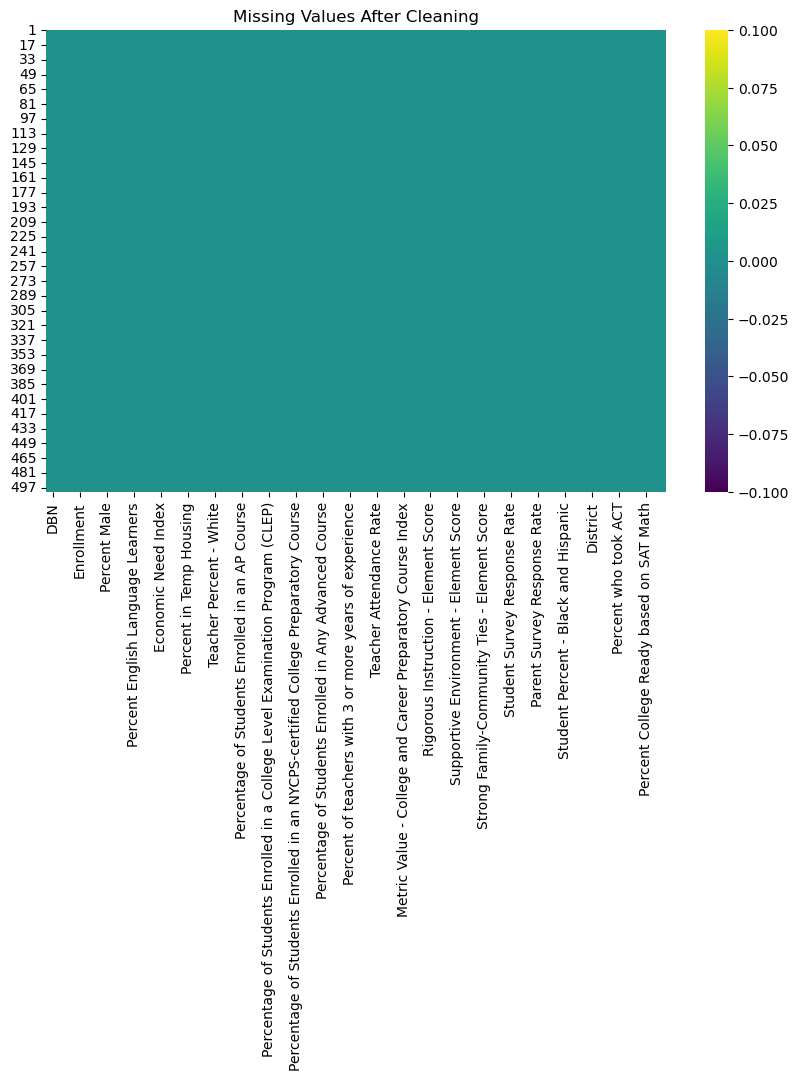

In [405]:
# post cleaning missingness check
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=True, cmap="viridis")
plt.title("Missing Values After Cleaning")
plt.show()